# <center><font color='red'> TME 1 - Arbres de décision, sélection de modèles </font></center>

## <center><code style="background:yellow; color:black"> L’essentiel sur les arbres de décision </code></center>

Un arbre de décision est un modèle de classification hiérarchique : pour des exemples sous la représentation $x = (x_1, x_2, . . . , x_d) ∈ R^d$, à chaque nœud de l’arbre est associé un test sur une des dimensions $x_i$ de la forme $x_i ≤ s$ ou $x_i > s$, avec $s$ une valeur réelle. Ce test indique le nœud fils qui doit être sélectionné (par exemple pour un arbre binaire, le fils gauche quand le test est vrai, le fils droit sinon). À chaque feuille de l’arbre est associée une étiquette. Ainsi, la classification d’un exemple consiste enune succession de tests sur les valeurs des dimensions de l’exemple, selon un chemin dans l’arbre de la racine à une des feuilles. La feuille atteinte donne la classe prédite. L’apprentissage de l’arbre s’effectue de manière récursive gloutonne top-down : à chaque nœud, l’algorithme doit choisir un test optimal, c’est-à-dire à la fois sur quelle dimension faire le test et quel seuillage appliqué (ce qu’on appelle un split). La mesure d’optimalité est en général une mesure d’homogénéité sur la partition obtenue, usuellement l’entropie de Shanon ou l’index de Gini : l’entropie d’une partition est d’autant plus petite qu’une classe prédomine dans chaque sous-ensemble de la partition, elle est nulle lorsque la séparation est parfaite (un seul label présent dans chacune des partitions) et maximale lorsque l’ensemble est le plus désordonné possible (équiprobabilité des labels dans chaque partition). Pour calculer le split optimal, chaque dimension de l’espace de description est considérée itérativement ; pour une dimension $i$, les exemples sont triés par rapport à la valeur de l’attribut de cette dimension $x_i$, puis pour chaque split possible, le calcul de l’homogénéité des deux partitions obtenues (en termes de label) par ce split est effectué. Le split ayant la meilleure homogénéité est alors choisi. Bien que l’algorithme pourrait continuer récursivement jusqu’à n’obtenir que des feuilles contenant un ensemble pur d’exemples (d’une seule classe - si les exemples sont séparables, i.e. il n’y a pas deux exemples de label opposé avec une même description), on utilise souvent des critères d’arrêts (pourquoi ? - nous y reviendrons lors de ce TP). Les plus utilisés sont le nombre d’exemples minimumque doit contenir un nœud pour être divisé (critère local) et la profondeur maximale de l’arbre (critère global).

## Exercice 1 - Entropie

1. Soit un objet itérable $vect$ (une liste ou un vecteur **numpy** par exemple) qui contient une liste de label. Coder une fonction $entropie (vect)$ qui calcule l’entropie de ce vecteur : $H(Y) = \sum_{y∈Y} p_y*log(p_y)$, $p_y$ correspond à la probabilité du label $y$ dans le vecteur $vect$. Penser à utiliser l’objet $Counter$ du module $collections$ qui permet de faire un histogramme des éléments d’une liste.

In [1]:
import numpy as np
import collections as clt
import pickle
import pydot
import matplotlib.pyplot as plt

In [2]:
def p_log_p(freq):
    """ fonction pour calculer \sum p_i log(p_i) """
    return np.nan_to_num(np.sum(freq*np.log2(freq)))

def entropy(y):
    """ calcul de l'entropie d'un ensemble"""
    ylen = float(y.size)
    if ylen <= 1:
        return 0
    freq = np.array(list(clt.Counter(y).values()))/ylen
    return -p_log_p(freq)

2. L’entropie conditionnelle permet de calculer l’homogénéité de la partition obtenue. Dans le cas général d’un split n-aire en n partitions $P = {P_1, . . . , P_n}$, l’entropie conditionnelle à $P$ s’écrit $H(Y|P) = \sum_{i}p(P_i)*H(Y|P_i)$, avec $H(Y|Pi) = -\sum_{y∈Y}p(y|P_i)*log(p(y|P_i))$ l’entropie des labels conditionnée à la partition considérée, et $p(P_i) = |P_i| / \sum_{j}P_j$, la proportion d’éléments dans $P_i$. <br>Coder la fonction entropie_cond(list_vect) qui à partir d’une liste de listes de labels (la partition des labels), calcule l’entropie conditionnelle de la partition.

In [3]:
def entropy_cond(y_list):
    h, total = 0.,0.
    for y in y_list:
        h += len(y)*entropy(y)
        total += len(y)
    return h/total

3. Le code suivant permet de charger un extrait de la base imdb (à télécharger sur le site de l’ue)

In [4]:
# data : tableau (films ,features)
# id2titles : dictionnaire  id -> titre ,
# fields : id  feature  -> nom
[data , id2titles , fields ] = pickle.load(open("imdb_extrait.pkl","rb"))
# la  derniere  colonne  est le vote
datax = data [: ,:32]
datay = np.array ([1 if x[33] >6.5  else  -1 for x in data])
print(len(id2titles))

4587


Chaque ligne du tableau data correspond à la description d’un film (le titre dans $id2titles$), chaque colonne à un attribut (dont la signification est donnée par $fields$). La plupart sont des genres (action, comédie, ...), la valeur 1 indique l’appartenance du film au genre, 0 sinon. Les dernières colonnes concernent l’année de production, la durée du film, le budget, le nombre de vote et la note moyenne attribuée au film. On binarise la note moyenne afin d’avoir deux classes, les films de note supérieure à 6.5, et les autres (vecteur $datay$). <br> Calculer pour chaque attribut binaire l’entropie et l’entropie conditionnelle du vote selon la partition induite par l’attribut (les exemples dont la valeur de l’attribut est 1 vs les autres). Calculer également la différence entre l’entropie et l’entropie conditionnelle pour chaque attribut. A quoi correspond une valeur de 0 ? une valeur de 1 ? Quel est le meilleur attribut pour la première partition ?

In [5]:
def getAllEntropies(datax, datay, fields):
    allEnt = dict()
    for key, value in fields.items():
        if key <= 27:
            ent = entropy(datax[:,key])
            entCond = entropy_cond([datax[:,key], datay])
            allEnt[value] = [ent, entCond, ent-entCond]
    return allEnt

getAllEntropies(datax, datay, fields)

{'Sci-Fi': [0.564976837274551, 0.7759428920883399, -0.21096605481378894],
 'Crime': [0.7256620117131098, 0.8562854793076193, -0.1306234675945095],
 'Romance': [0.7540946843905093, 0.870501815646319, -0.1164071312558097],
 'Animation': [0.2634038042219715, 0.6251563755620502, -0.36175257134007865],
 'Music': [0.1926285852674641, 0.5897687660847964, -0.3971401808173324],
 'Comedy': [0.9487805443246595, 0.9678447456133942, -0.01906420128873465],
 'War': [0.2653268692430364, 0.6261179080725825, -0.3607910388295461],
 'Horror': [0.5347013539632184, 0.7608051504326735, -0.2261037964694551],
 'Film-Noir': [0.040466328209344704, 0.5136876375557368, -0.47322130934639206],
 'Adult': [-0.0, 0.49345447345106436, -0.49345447345106436],
 'News': [-0.0, 0.49345447345106436, -0.49345447345106436],
 'Reality-TV': [-0.0, 0.49345447345106436, -0.49345447345106436],
 'Thriller': [0.9104758524619008, 0.9486923996820149, -0.03821654722011414],
 'Western': [0.13310901662996316, 0.560008981766046, -0.42689996

<font color="blue"> Si l'entropie a une valeur de 0 alors l'échantillon est homogène (seulement des 0 ou 1), si elle a une valeur de 1 alors l'échantillon est divisé en parts égales (autant de 0 que de 1). <br> 
Le gain d'information est calculé de la façon suivante : $entropy(T) - entropy$_$cond(T,X)$, plus cette valeur est grande plus l'information apportée par l'attribut $X$ sera pertinente et donc choisi pour faire le split. <br>
Le meilleur attribut est "drama" avec un gain de 0.0065.</font>

## <center><code style="background:yellow; color:black"> Quelques expériences préliminaires </code></center>

Tous les modèles d’apprentissage que nous étudierons seront calqués (hérités, mais la notion d’héritage en python est optionnelle) sur la classe Classifier, munie d’un constructeur (qui permet d’initialiser les paramètres, variables d’instance de l’objet), d’une méthode **fit(data,labels)** qui permet d’apprendre le modèle sur les données en paramètre, d’une méthode **predict(data)** qui permet d’obtenir un vecteur de prédiction pour les données passées en paramètre, et d’une méthode **score(data,labels)** qui permet de renvoyer le pourcentage de bonne classification des données par rapport aux labels passés en paramètre. Le code suivant permet de créer, d’apprendre un arbre de décision et de l’utiliser :

In [19]:
###############################
# Classes
###############################


class Classifier(object):
    """ Classe generique d'un classifieur
        Dispose de 3 méthodes :
            fit pour apprendre
            predict pour predire
            score pour evaluer la precision
    """
    def fit(self,data,y):
        raise NotImplementedError("fit non  implemente")
    def predict(self,data):
        raise NotImplementedError("predict non implemente")
    def score(self,data,y):
        return (self.predict(data)==y).mean()


class Split(object):
    """ Permet de coder un split pour une variable continue
    """
    def __init__(self,idvar=None,threshold=None,gain=None):
        """
        :param idvar: numero de la variable de split
        :param threshold: seuil
        :param gain: gain d'information du split
        :return:
        """
        self.idvar=idvar
        self.threshold=threshold
        self.gain=gain

    def predict(self,data):
        """ Prediction pour une matrice d'exemples, -1 si <= threshold, +1 sinon
        :param x: matrice d'exemples
        :return: vecteur des labels
        """
        if len(data.shape)==1:
            data=data.reshape((1,data.shape[0]))
        return [-1 if data[i,self.idvar]<=self.threshold else 1 for i in range(data.shape[0])]

    @staticmethod
    def best_gain(x,y):
        """  calcul le meilleur seuil pour la colonne x (1-dimension) et les labels y
        :param x: vecteur 1d des donnees
        ;param y: vecteur des labels
        :return:
        """
        ylen = float(y.size)
        idx_sorted = np.argsort(x)
        h=entropy(y)
        xlast=x[idx_sorted[0]]
        split_val=x[idx_sorted[0]]
        hmin = h
        for i in range(y.size):
            if x[idx_sorted[i]]!=xlast:
                htmp = entropy_cond([y[idx_sorted[:i]], y[idx_sorted[i:]]])
                if htmp<hmin:
                    hmin=htmp
                    split_val=(xlast+x[idx_sorted[i]])/2.
            xlast=x[idx_sorted[i]]
        return (h-hmin/ylen),split_val

    @staticmethod
    def find_best_split(data,y):
        if len(data.shape)==1:
            data = data.reshape((1,data.shape[0]))
        hlist = [[Split.best_gain(data[:,i],y),i] for i in range(data.shape[1])]
        (h,threshold),idx= max(hlist)
        return Split(idx,threshold,h)

    def __str__(self):
        return "var %s, thresh %f (gain %f)" %(self.idvar,self.threshold, self.gain)

class Node(Classifier):
    """ Noeud d'un arbre
    """
    def __init__(self,split=None,parent=None,left=None,right=None,leaf=True,depth=-1,label=None,**kwargs):
        """
        :param split:  split du noeud
        :param parent: noeud parent, None si root
        :param left: fils gauche
        :param right: fils droit
        :param leaf: boolean vrai si feuille
        :param depth: profondeur
        :param label: label preponderant
        :return:
        """
        self.split, self.parent, self.left, self.right, self.leaf, self.label, self.depth = \
                                            split, parent, left, right, leaf, label, depth
        self.info = dict(kwargs)

    def predict(self,data):
        if len(data.shape)==1:
            data=data.reshape((1,data.shape[0]))
        if self.leaf:
            return [self.label]*data.shape[0]
        return [self.left.predict(data[i,:])[0] if res<0 else self.right.predict(data[i,:])[0]
                for i, res in enumerate(self.split.predict(data))]

    def fit(self, data, y):
        counts=clt.Counter(y)
        self.split=Split.find_best_split(data, y)
        self.label = counts.most_common()[0][0]

    def __str__(self):
        if self.leaf:
            return "Leaf : %s" % (self.label,)
        return "Node : %s (%s)" % (self.split,self.info)

class DecisionTree(Classifier):
    """ Arbre de decision
    """

    def __init__(self,max_depth=None,min_samples_split=2):
        """
        :param max_depth: profondeur max
        :param min_samples_split:  nombre d'exemples minimal pour pouvoir spliter le noeud
        :return:
        """
        self.max_depth, self.min_samples_split = max_depth, min_samples_split
        self.root = None

    def fit(self,data,y):
        """ apprentissage de l'arbre de maniere iterative
        on apprend un noeud, puis on cree les deux enfants de ce noeud, que l'on ajoute a la pile des noeuds
        a traiter par la suite (nodes_to_treat), ainsi que les index des exemples associes (dic_idx)
        """
        self.root = Node(depth=0)
        nodes_to_treat = [self.root]
        dic_idx = dict({self.root : range(len(y))})
        while len(nodes_to_treat)>0:
            # recuperation du noeud courant
            curnode = nodes_to_treat.pop()
            #recuperation de la liste des indices des exemples associes, x[idx_train,:] contient l'ensemble des
            #exemples a traiter
            idx_train = dic_idx.pop(curnode)
            # infos complementaires sur le nombre d'exemples en apprentissage par label
            for lab,clab in clt.Counter(y[idx_train]).items():
                curnode.info[lab]=clab
            curnode.fit(data[idx_train,:],y[idx_train])

            # recupere les predictions pour partager entre fils droit et gauche les exemples
            pred = curnode.split.predict(data[idx_train,:])
            l_idx = [ idx_train[i] for i in range(len(idx_train)) if pred[i]<0 ]
            r_idx = list(set(idx_train).difference(l_idx))

            #Condition d'arrets
            if entropy(y[idx_train])==0 or curnode.depth >= self.max_depth or \
                    len(l_idx) < self.min_samples_split or len(r_idx) < self.min_samples_split:
                curnode.leaf=True
                continue
            #Creation des deux enfants
            curnode.left = Node(parent=curnode,depth=curnode.depth+1)
            curnode.right = Node(parent=curnode,depth=curnode.depth+1)
            curnode.leaf = False
            #On enregistre les indices correspondant aux deux noeuds
            dic_idx[curnode.left]=l_idx
            dic_idx[curnode.right]=r_idx
            #On ajoute les deux enfants a la liste des noeuds a traiter
            nodes_to_treat = [curnode.left,curnode.right]+nodes_to_treat

    def predict(self,data):
        return self.root.predict(data)

    def __str__(self):
        return self.print_tree()

    def to_dot(self,dic_var=None):
        s="digraph Tree {"
        cpt=0
        nodes = [(self.root,cpt)]
        while len(nodes)>0:
            curnode,idx = nodes.pop()
            labinfo = ",".join(["%s: %s" % (lab,slab) for lab,slab in curnode.info.items()])
            if not curnode.leaf:
                s+="%d [label=\"%s <= %f\n IG=%f\n " %(idx,curnode.split.idvar \
                    if not dic_var else dic_var[curnode.split.idvar],curnode.split.threshold,curnode.split.gain)
                s+= " %s \n \",shape=\"box\" ];\n"  % (labinfo,)
                lidx = cpt +1
                ridx = cpt +2
                s+= "%d -> %d; %d -> %d;\n" % (idx,lidx,idx,ridx)
                cpt+=2
                nodes += [(curnode.left,lidx),(curnode.right,ridx)]
            else:
                s+= "%d [label=\"label=%s\n %s \"];\n" %(idx,curnode.label,labinfo)
        return s+"}"

    def to_pdf(self,filename,dic_var=None):
        pydot.graph_from_dot_data(self.to_dot(dic_var))[0].write_pdf(filename)

    def print_tree(self,fields=None):
        s=""
        nodes=[self.root]
        while len(nodes)>0:
            curnode=nodes.pop()
            if type(curnode)==str:
                s+=curnode
            else:
                if not curnode.leaf:
                    s+= "\t"*curnode.depth + "var %s :  > %f \n"  %(str(curnode.split.idvar) if not fields else fields[curnode.split.idvar],curnode.split.threshold)
                    nodes+=[curnode.left, "\t"*curnode.depth + "var %s :  <= %f \n"  %(str(curnode.split.idvar) if not fields else fields[curnode.split.idvar],curnode.split.threshold), curnode.right]
                else:
                    s+= "\t"*curnode.depth + "class : %s %s\n" %(curnode.label,str(curnode.info))
        return s


4. Sur la base de données imdb, apprendre quelques arbres de profondeurs différentes. Visualiser-les. Que remarquez-vous quant au nombre d’exemples séparés à chaque niveau en fonction de la profondeur ? est-ce normal ?

In [20]:
dt = DecisionTree()
dt.max_depth = 5 # on fixe la  taille  de l’arbre a 5
dt.min_samples_split = 2 # nombre  minimum d’exemples  pour  spliter  un noeud
dt.fit(datax ,datay)
dt.predict(datax [:5 ,:])
print(dt.score(datax ,datay)) # dessine l’arbre dans un  fichier  pdf si pydot  est  installe.
#dt.to_pdf("test_tree.pdf",fields) # sinon  utiliser  http :// www.webgraphviz.com/
dt.to_dot(fields) #ou dans la  console
print(dt.print_tree(fields ))

0.736429038587312
var Drama :  > 0.500000 
	var budget :  > 15660000.000000 
		var Duree :  > 115.500000 
			var budget :  > 36500000.000000 
				var Duree :  > 137.500000 
					class : 1 {1: 101, -1: 20}
				var Duree :  <= 137.500000 
					class : 1 {-1: 94, 1: 109}
			var budget :  <= 36500000.000000 
				var Sci-Fi :  > 0.500000 
					class : -1 {-1: 5, 1: 4}
				var Sci-Fi :  <= 0.500000 
					class : 1 {1: 252, -1: 31}
		var Duree :  <= 115.500000 
			var Biography :  > 0.500000 
				var annee :  > 2011.500000 
					class : -1 {-1: 2}
				var annee :  <= 2011.500000 
					class : 1 {1: 24, -1: 2}
			var Biography :  <= 0.500000 
				var Thriller :  > 0.500000 
					class : -1 {-1: 162, 1: 66}
				var Thriller :  <= 0.500000 
					class : -1 {1: 135, -1: 149}
	var budget :  <= 15660000.000000 
		var annee :  > 1973.500000 
			var Duree :  > 104.500000 
				var budget :  > 11158052.500000 
					class : 1 {1: 131, -1: 39}
				var budget :  <= 11158052.500000 
					class : 1 {-1: 25,

5. Calculer les scores de bonnes classification. Comment ils évoluent en fonction de la profondeur ? Est-ce normal ?

NameError: name 'scores' is not defined

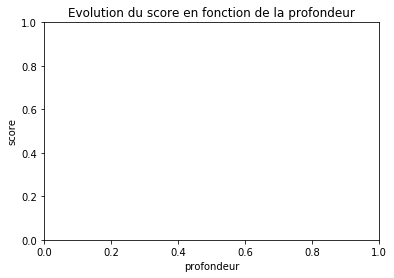

In [21]:
def getScores(datax, labels, nprof):
    dt = DecisionTree()
    scores = []
    for i in range(1, nprof+1):
        dt.max_depth = i # on fixe la  taille  de l’arbre a 5
        dt.min_samples_split = 2 # nombre  minimum d’exemples  pour  spliter  un noeud
        dt.fit(datax, labels)
        dt.predict(datax [:5 ,:])
        scores.append(dt.score(datax, labels))
    return scores

# scores = getScores(datax, datay, 10)

# Affichage évolution des scores
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("profondeur")
plt.ylabel("score")
plt.title("Evolution du score en fonction de la profondeur")
ax.plot(np.arange(len(scores)), scores, color='tab:blue')


<font color="blue"> Plus la profondeur est grande et plus le score augmente, c'est tout à fait normal car notre arbre de décision "se cale sur nos données" rendant la prédiction de plus en plus précise => sur-apprentissage </font>

6. Ces scores sont-ils un indicateur fiable du comportement de l’algorithme ? Comment obtenir un indicateur plus fiable ?

<font color="blue"> Ces scores ne sont évidemment pas fiables car nos données qui nous servent à faire la prédiction sont les mêmes qui nous servent d'apprentissage, il faudrait séparer nos données en deux parties : apprentissage et test </font>

## <center><code style="background:yellow; color:black"> Sur et sous apprentissage </code></center>

Pour obtenir une meilleure estimation de l’erreur du classifieur appris, il est usuel d’utiliser deux ensembles d’exemples étiquetés :
<ul>
    <li>l’ensemble d’apprentissage : l’apprentissage du classifieur ne se fait que sur ce sous-ensemble d’exemples ; </li>
    <li>l’ensemble de test : cet ensemble sert à évaluer l’erreur du classifieur. </li> 
</ul>
Ces deux sous-ensembles sont tirés de manière aléatoire en faisant une partition en 2 parties des exemples disponibles. L’erreur faîte sur l’ensemble d’apprentissage s’appelle l’erreur d’apprentissage, celle sur l’ensemble de test l’erreur de test.

7. Pour différents partitionnement, par exemple des partages en (0.2,0.8), (0.5,0.5), (0.8,0.2), tracer les courbes de l’erreur en apprentissage et de l’erreur en test en fonction de la profondeur du modèle.

In [ ]:
def splitTrainTest(data, labels, pc_train):
    index = np.random.permutation(len(labels))
    napp = int(len(labels)*pc_train) 
    X_train, y_train = data[index[:napp]], labels[index[:napp]]
    X_test, y_test   = data[index[napp:]], labels[index[napp:]]
    return X_train, y_train, X_test, y_test

In [ ]:
def getErrors(data, labels, nprof, pc_train):
    dt = DecisionTree()
    errApp = []
    errTest = []
    X_train, y_train, X_test, y_test = splitTrainTest(data, labels, pc_train)
    for i in range(1, nprof+1):
        dt.max_depth = i # on fixe la  taille  de l’arbre a 5
        dt.min_samples_split = 2 # nombre  minimum d’exemples  pour  spliter  un noeud
        dt.fit(X_train, y_train)
        dt.predict(X_test)
        errApp.append(1 - dt.score(X_train, y_train))
        errTest.append(1 - dt.score(X_test, y_test))
    return errApp, errTest

errApp_08, errTest_02 = getErrors(datax, datay, 20, 0.8)
errApp_05, errTest_05 = getErrors(datax, datay, 20, 0.5)
errApp_02, errTest_08 = getErrors(datax, datay, 20, 0.2)

# Affichage évolution des erreurs
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("profondeur")
plt.ylabel("erreur")
plt.title("Evolution de l'erreur en fonction de la profondeur 0.2/0.8")
ax.plot(np.arange(len(errApp_02)), errApp_02, color='tab:blue')
ax.plot(np.arange(len(errTest_08)), errTest_08, color='tab:orange')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("profondeur")
plt.ylabel("erreur")
plt.title("Evolution de l'erreur en fonction de la profondeur 0.5/0.5")
ax.plot(np.arange(len(errApp_05)), errApp_05, color='tab:blue')
ax.plot(np.arange(len(errTest_05)), errTest_05, color='tab:orange')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("profondeur")
plt.ylabel("erreur")
plt.title("Evolution de l'erreur en fonction de la profondeur 0.8/0.2")
ax.plot(np.arange(len(errApp_08)), errApp_08, color='tab:blue')
ax.plot(np.arange(len(errTest_02)), errTest_02, color='tab:orange')

8. Que remarquez vous quand il y a peu d’exemples d’apprentissage ? Comment progresse l’erreur ? De même quand il y a beaucoup d’exemples d’apprentissage. Est-ce le même comportement pour les deux erreurs ?

<font color="blue"> Lorsqu'il y a peu d'exemples 

9. Vos résultats vous semblent ils fiables et stables ? Comment les améliorer ?

<font color="blue"> Non. Cross-validation </font>

## <center><code style="background:yellow; color:black"> Validation croisée : sélection de modèle </code></center>

Il est rare de disposer en pratique d’un ensemble de test (on préfère inclure le plus grand nombre de données dans l’ensemble d’apprentissage). Pour sélectionner un modèle tout en considérant le plus grand nombre d’exemples possible pour l’apprentissage, on utilise généralement une procédure dite de sélection par validation croisée. Pour chaque paramétrisation de l’algorithme, une estimation de l’erreur empirique du classifieur appris est faîte selon la procédure suivante :
<ul>
    <li>l’ensemble d’apprentissage $E_{app}$ est partitionné en *n* ensembles d’apprentissage ${E_i}$ </li>
    <li>Pour $i = 1..n$ </li>
        <ul>
            <li> l’arbre est appris sur $E_{app}$ \ $E_i$ </li>
            <li> l’erreur en test $err(E_i)$ est évaluée sur $E_i$ (qui n’a pas servi à l’apprentissage à cette itération) </li>
            <li> l’erreur moyenne $err = \frac{1}{n} \sum_{i=1}^{n}err(E_i)$ est calculée, le modèle sélectionné est celui qui minimise cette erreur </li>
        </ul>
</ul>
<br>
Refaire les expériences précédentes avec cette fois de la validation croisée (penser à la fonction **np.random.shuffle**).

In [88]:
def shuffle(data, labels):
    index = np.random.shuffle(np.arange(len(labels)))
    data_shu = data[index]
    labels_shu = labels[index]
    return data_shu, labels_shu

def cross_validation(data, labels, n, nprof):
    # Step 1 : Shuffle
    data_shu, labels_shu = shuffle(data, labels)
    
    # Step 2 : split equals parts
    inter = np.linspace(0, len(labels), n+1)
    print(inter)
    
    # Step 3 : initiate decision tree
    dt = DecisionTree()
    dt.max_depth = nprof
    dt.min_samples_split = 2 #nombre  minimum d’exemples  pour  spliter  un noeud
    mean_err = []
    
    # Step 4 : iterate over data
    for i in range(n):
        test_x, test_y = data_shu[0][ int(inter[i]): int(inter[i+1]) ], labels_shu[0][ int(inter[i]) : int(inter[i+1]) ]
        if i == 0:
            train_x, train_y = data_shu[0][ int(inter[1]) : int(inter[n-1]) ], labels_shu[0][ int(inter[1]) : int(inter[n-1]) ]
        elif i == n-2:
            train_x, train_y = data_shu[0][ int(inter[0]) : int(inter[n-2]) ], labels_shu[0][ int(inter[0]) : int(inter[n-2])]
        else:
            train_x = np.vstack( ( data_shu[0][ int(inter[0]) : int(inter[i]) ], data_shu[0][ int(inter[i+1]) : int(inter[n-1]) ] ) ) 
            train_y = np.hstack( ( labels_shu[0][ int(inter[0]) : int(inter[i]) ], labels_shu[0][ int(inter[i+1]) : int(inter[n-1]) ] ) )
            
        dt.fit(train_x, train_y)
        dt.predict(test_x)
        mean_err.append(1 - dt.score(test_x, test_y))
        
    return np.array(mean_err).mean()

In [ ]:
mean_err = []
for i in range(1, 11):
    mean_err.append(cross_validation(datax, datay, 10, i))

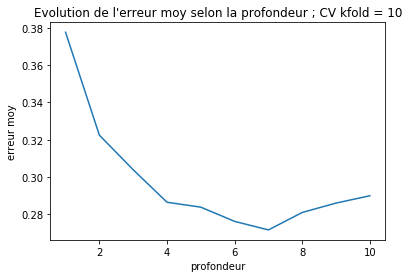

In [92]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("profondeur")
plt.ylabel("erreur moy")
plt.title("Evolution de l'erreur moy selon la profondeur ; CV kfold = 10")
ax.plot(np.arange(1,len(mean_err)+1), mean_err, color='tab:blue')